In [1]:
import pandas as pd
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle
import re

# Aggregate and extract all variables (takes time and memory)

In [2]:
%%time
# Define the directory path
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
region_name = "Australian Capital Territory"

# List of station number prefixes to filter
prefixes = ['07'] # brisbane ['04','14'], perth ['009'], adelaide ['02'], sydney ['06'], hobart ['09'], Darwin ['01'], ACT ['07']

# List all .nc files in the directory
file_list = [f for f in os.listdir(directory_path) if f.endswith('.nc')]

# Compile regex pattern to match files with specified station number prefixes
pattern_str = rf"HD01D_Data_((?:{'|'.join(prefixes)})\d*)_\d+\.nc"
netcdf_pattern = re.compile(pattern_str)

# Filter files matching the pattern
matched_files = [f for f in file_list if netcdf_pattern.match(f)]

# Define aggregation intervals (assuming 5‑min time steps)
intervals = {'10min': 2, '1h': 12}
interval_order = ['10min', '1h']

# Initialize dictionaries
event_windows_noNAN_all_stations = {}
file_station_mapping = {}
station_name_count = {}

for file_name in matched_files:
    file_path = os.path.join(directory_path, file_name)
    
    with xr.open_dataset(file_path) as data:
        # Extract station name and clean it
        station_name = data.attrs.get('Station_name', 'Unknown Station').strip()
        
        # Clean station names by removing/standardizing unwanted terms
        station_name_clean = station_name.replace("AWS", "").strip()

        # Store file-station mapping
        file_station_mapping[file_name] = station_name_clean

        # Required variables
        required_vars = ['Precipitation', 'Precipitation Quality', 
                         'Temperature', 'Temperature Quality',
                         'Dew Point Temperature', 'Dew Point Temperature Quality', 
                         'Average Wind Speed', 'Average Wind Speed Quality']
        
        # Check for missing variables
        available_vars = list(data.variables)
        missing_vars = [var for var in required_vars if var not in available_vars]
        if missing_vars:
            print(f"Skipping {station_name_clean}: Missing variables {missing_vars}")
            continue  # Skip this station if required variables are missing
        
        # Extract data
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']
        temp = data['Temperature']
        temp_q = data['Temperature Quality']
        dew_point_temp = data['Dew Point Temperature']
        dew_point_temp_q = data['Dew Point Temperature Quality']
        wind_speed = data['Average Wind Speed']
        wind_speed_q = data['Average Wind Speed Quality']
        
        # Apply quality filters
        ppt = ppt.where(ppt_q.astype(str) == 'Y')
        ppt = ppt.where(ppt <= 50)
        temp = temp.where(temp_q == 'Y')
        dew_point_temp = dew_point_temp.where(dew_point_temp_q == 'Y')
        wind_speed = wind_speed.where(wind_speed_q == 'Y')
        
        # Calculate Relative Humidity
        rh = 100 * (np.exp((17.27 * dew_point_temp) / (dew_point_temp + 237.3)) /
                    np.exp((17.27 * temp) / (temp + 237.3)))
        rh = np.round(rh, 2)
        rh.name = 'Relative Humidity'
        
        # Convert each variable to DataFrame and set Time as the index
        def to_dataframe(var, var_name):
            df = var.to_dataframe().reset_index()
            df['Time'] = pd.to_datetime(df['Time'])
            df = df.set_index('Time')
            df = df.rename(columns={df.columns[-1]: var_name})
            return df
        
        ppt_df = to_dataframe(ppt, 'Precipitation')
        temp_df = to_dataframe(temp, 'Temperature')
        rh_df = to_dataframe(rh, 'Relative Humidity')
        wind_speed_df = to_dataframe(wind_speed, 'Wind Speed')

        # Aggregate data
        all_vars_aggregated_data = {}
        for interval, window in intervals.items():
            df = pd.DataFrame(index=ppt_df.index)
            df['Precipitation'] = ppt_df['Precipitation'].rolling(window=window, min_periods=1).apply(lambda x: 0 if np.isnan(x).any() else x.sum(), raw=True)
            df['Temperature'] = temp_df['Temperature'].rolling(window=window, min_periods=1).mean()
            df['Relative Humidity'] = rh_df['Relative Humidity'].rolling(window=window, min_periods=1).mean()
            df['Wind Speed'] = wind_speed_df['Wind Speed'].rolling(window=window, min_periods=1).mean()
            
            # Store aggregated data
            all_vars_aggregated_data[interval] = df.reset_index()

        # Save the extracted event windows
        event_windows_noNAN_all_stations[station_name_clean] = all_vars_aggregated_data

CPU times: user 1min 24s, sys: 3.12 s, total: 1min 27s
Wall time: 1min 30s


In [3]:
# save
with open(f'{directory_path}/p2_event_windows_noNAN_all_stations_{region_name}.pkl', 'wb') as f:
    pickle.dump(event_windows_noNAN_all_stations, f)

In [ ]:
%%time

# Define the directory path
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
file_list = [f for f in os.listdir(directory_path) if f.endswith('.nc')]

# Define aggregation intervals (assuming 5-min time steps)
# For example, for 10min: window=2 (2 * 5min), for 1h: window=12 (12 * 5min)
intervals = {'10min': 2, '1h': 12}
interval_order = ['10min', '1h']

# Initialize dictionaries
event_windows_noNAN_all_stations_revised = {}
file_station_mapping = {}
station_name_count = {}

def custom_rolling_sum(s, window):
    """Vectorized rolling sum that returns 0 if the window has any NaN, else returns the sum."""
    rsum = s.rolling(window=window, min_periods=window).sum()
    rcount = s.rolling(window=window, min_periods=window).count()
    # For complete window, count equals window; otherwise, set to 0
    return rsum.where(rcount == window, 0)

# Process each file (each station)
for file_name in file_list:
    file_path = os.path.join(directory_path, file_name)
    
    with xr.open_dataset(file_path) as data:
        # Extract and clean station name from attributes
        station_name = data.attrs.get('Station_name', 'Unknown Station').strip()
        station_name_clean = station_name.replace("AWS", "").strip()
        file_station_mapping[file_name] = station_name_clean

        # Check for required variables
        required_vars = ['Precipitation', 'Precipitation Quality', 
                         'Temperature', 'Temperature Quality',
                         'Dew Point Temperature', 'Dew Point Temperature Quality', 
                         'Average Wind Speed', 'Average Wind Speed Quality']
        missing_vars = [var for var in required_vars if var not in data.variables]
        if missing_vars:
            print(f"Skipping {station_name_clean}: Missing {missing_vars}")
            continue

        # Extract data variables
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']
        temp = data['Temperature']
        temp_q = data['Temperature Quality']
        dew_point_temp = data['Dew Point Temperature']
        dew_point_temp_q = data['Dew Point Temperature Quality']
        wind_speed = data['Average Wind Speed']
        wind_speed_q = data['Average Wind Speed Quality']

        # Apply quality filters
        ppt = ppt.where(ppt_q.astype(str) == 'Y').where(ppt <= 50)
        temp = temp.where(temp_q == 'Y')
        dew_point_temp = dew_point_temp.where(dew_point_temp_q == 'Y')
        wind_speed = wind_speed.where(wind_speed_q == 'Y')

        # Calculate Relative Humidity
        rh = 100 * (np.exp((17.27 * dew_point_temp) / (dew_point_temp + 237.3)) /
                    np.exp((17.27 * temp) / (temp + 237.3)))
        rh = np.round(rh, 2)
        rh.name = 'Relative Humidity'

        # Function to convert variable to DataFrame (only once per variable)
        def to_df(var, var_name):
            df = var.to_dataframe().reset_index()
            df['Time'] = pd.to_datetime(df['Time'])
            df = df.set_index('Time')
            df = df.rename(columns={df.columns[-1]: var_name})
            return df

        ppt_df = to_df(ppt, 'Precipitation')
        temp_df = to_df(temp, 'Temperature')
        rh_df = to_df(rh, 'Relative Humidity')
        wind_speed_df = to_df(wind_speed, 'Wind Speed')

        # Initialize dictionary to store aggregated data
        ppt_aggregated = {}
        for interval, window in intervals.items():
            # For precipitation: use custom rolling sum to ensure full data; for others, standard rolling mean.
            agg_df = pd.DataFrame(index=ppt_df.index)
            agg_df['Precipitation'] = custom_rolling_sum(ppt_df['Precipitation'], window)
            agg_df['Temperature'] = temp_df['Temperature'].rolling(window=window, min_periods=window).mean()
            agg_df['Relative Humidity'] = rh_df['Relative Humidity'].rolling(window=window, min_periods=window).mean()
            agg_df['Wind Speed'] = wind_speed_df['Wind Speed'].rolling(window=window, min_periods=window).mean()
            ppt_aggregated[interval] = agg_df.reset_index()

        # Store aggregated data for the station
        event_windows_noNAN_all_stations_revised[station_name_clean] = ppt_aggregated

In [ ]:
# save
with open(f'{directory_path}/p2_event_windows_noNAN_all_stations_revised.pkl', 'wb') as f:
    pickle.dump(event_windows_noNAN_all_stations_revised, f)

# Selecting top 10 events

In [4]:
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
with open(f'{directory_path}/p2_event_windows_noNAN_all_stations_{region_name}.pkl', 'rb') as f:
    event_windows_all_stations = pickle.load(f)

# interval_order = ['10min', '1h']
interval_order = ['10min']

In [5]:
directory_path = "/scratch/w28/lk5320/p2_event_windows_noNAN_all_stations.pkl"
with open(f'{directory_path}', 'rb') as f:
    event_windows_all_stations = pickle.load(f)

In [36]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Settings
PERCENTILE_THRESHOLD = 0.90
MIN_VALUE = 0.2
intervals = {"10min": "Daily_Max_10min", "1h": "Daily_Max_1h"}

# Helper: Extract top daily maxima
def extract_top_daily_max(df, percentile_threshold, min_value, label, top_n=10):
    df = df.copy()
    if 'Time' not in df.columns:
        df = df.reset_index()
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    threshold = df['Precipitation'].quantile(percentile_threshold)
    filtered = df[(df['Precipitation'] >= threshold) & (df['Precipitation'] > min_value)]

    maxima = filtered[
        (filtered.shift(-1).fillna(-1) <= filtered) &
        (filtered.shift(1).fillna(-1) <= filtered)
    ]

    daily_max = maxima.groupby(maxima.index.date)['Precipitation'].max()
    max_times = maxima.groupby(maxima.index.date)['Precipitation'].idxmax()

    df_out = pd.DataFrame({
        'Date': pd.to_datetime(daily_max.index.astype(str)),
        label: daily_max,
        f'Time_{label}': max_times.values
    }).sort_values(by=label, ascending=False).head(top_n)

    return df_out

# Store per-station 95th and 99th percentiles for 1h
yearly_95p_by_station = {}
yearly_99p_by_station = {}

top10_daily_events = []

# Main loop
for station, data_dict in event_windows_all_stations.items():
    if not all(k in data_dict for k in intervals):
        continue

    # Top 10 10min daily maxima (per station)
    df_10 = extract_top_daily_max(data_dict['10min'], PERCENTILE_THRESHOLD, MIN_VALUE, 'Daily_Max_10min', top_n=10)

    # Full 1h DataFrame to compute daily max
    df_1h = data_dict['1h'].copy()
    if 'Time' not in df_1h.columns:
        df_1h = df_1h.reset_index()
    df_1h['Time'] = pd.to_datetime(df_1h['Time'])
    df_1h.set_index('Time', inplace=True)
    df_1h['Date'] = df_1h.index.date

    # Daily max 1h from full data (not percentile-filtered)
    daily_max_1h = df_1h.groupby('Date')['Precipitation'].max()
    max_times_1h = df_1h.groupby('Date')['Precipitation'].idxmax()
    df_daily_1h = pd.DataFrame({
        'Date': pd.to_datetime(daily_max_1h.index.astype(str)),
        'Daily_Max_1h': daily_max_1h.values,
        'Datetime_1h_Max': max_times_1h.values
    })

    # Merge 10min top events with full 1h maxima
    merged = pd.merge(df_10, df_daily_1h, on='Date', how='left')
    merged['Station'] = station

    # Compute per-year 95th for 1h (non-zero)
    df_1h['Year'] = df_1h.index.year
    df_1h_nonzero = df_1h[df_1h['Precipitation'] > 0]
    yearly_95p = df_1h_nonzero.groupby('Year')['Precipitation'].quantile(0.95)
    yearly_95p_by_station[station] = yearly_95p
    yearly_99p = df_1h_nonzero.groupby('Year')['Precipitation'].quantile(0.99)
    yearly_99p_by_station[station] = yearly_99p
    
    top10_daily_events.append(merged)

# Combine all stations' top 10s
combined_df = pd.concat(top10_daily_events, ignore_index=True)
combined_df['Datetime_10min_Max'] = pd.to_datetime(combined_df['Time_Daily_Max_10min'])

# Flag whether 1h exceeds the 95th percentile of that year (non-zero only)
combined_df['Year'] = combined_df['Date'].dt.year
def flag_1h_percentile(row, percentile_dict, label):
    station = row['Station']
    year = row['Year']
    value = row['Daily_Max_1h']
    threshold = percentile_dict.get(station, {}).get(year, np.nan)
    return 'Y' if pd.notna(threshold) and value > threshold else 'N'

combined_df['Above_95p_1h'] = combined_df.apply(lambda row: flag_1h_percentile(row, yearly_95p_by_station, '95p'), axis=1)
combined_df['Above_99p_1h'] = combined_df.apply(lambda row: flag_1h_percentile(row, yearly_99p_by_station, '99p'), axis=1)
# combined_df['Date'] = pd.to_datetime(combined_df['Date']).dt.floor('D')

# Final clean output
final_cols = ['Date', 'Station', 
              'Daily_Max_10min', 'Datetime_10min_Max',
              'Daily_Max_1h', 'Datetime_1h_Max', 
              'Above_95p_1h', 'Above_99p_1h']

file_path = f'{shape_path}/figure/{region_name}_top10_all_stations_summary.csv'

print(combined_df[final_cols].sort_values(by='Daily_Max_10min', ascending=False))
combined_df[final_cols].to_csv(file_path, index=False)


          Date                    Station  Daily_Max_10min  \
60  2016-12-29                FERNY CREEK             33.2   
10  2005-01-13  MELBOURNE REGIONAL OFFICE             28.6   
140 2024-01-02                 COLDSTREAM             27.6   
110 2016-12-29                   VIEWBANK             27.2   
40  2022-03-24   MELBOURNE (OLYMPIC PARK)             27.0   
..         ...                        ...              ...   
79  2022-11-14            POINT COOK RAAF              6.6   
86  2020-12-22    FRANKSTON (BALLAM PARK)              6.6   
87  2024-01-08    FRANKSTON (BALLAM PARK)              6.0   
88  2022-10-06    FRANKSTON (BALLAM PARK)              5.6   
89  2023-11-25    FRANKSTON (BALLAM PARK)              5.6   

     Datetime_10min_Max  Daily_Max_1h     Datetime_1h_Max Above_95p_1h  \
60  2016-12-29 15:40:00          54.4 2016-12-29 16:20:00            Y   
10  2005-01-13 10:10:00          62.0 2005-01-13 10:30:00            Y   
140 2024-01-02 15:10:00          

In [2]:
def match_station_coords(station_name, station_info_df):
    clean_name = station_name.strip().lower()

    # Try exact match
    exact = station_info_df[
        station_info_df['Station_name'].str.strip().str.lower() == clean_name
    ]
    if not exact.empty:
        return exact.iloc[0]['Latitude'], exact.iloc[0]['Longitude']

    # Try input name in station_info name (e.g., 'HOLSWORTHY AERODROME' in 'HOLSWORTHY AERODROME AWS')
    contains_input = station_info_df[
        station_info_df['Station_name'].str.strip().str.lower().apply(lambda x: clean_name in x)
    ]
    if len(contains_input) == 1:
        return contains_input.iloc[0]['Latitude'], contains_input.iloc[0]['Longitude']

    # Try reverse: station_info name is substring of input
    contains_station = station_info_df[
        station_info_df['Station_name'].str.strip().str.lower().apply(lambda x: x in clean_name)
    ]
    if len(contains_station) == 1:
        return contains_station.iloc[0]['Latitude'], contains_station.iloc[0]['Longitude']

    return np.nan, np.nan

In [4]:
# Define the directory path
# directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
# region_name = "Brisbane"

# --- File and Path Setup ---
# Define the directory path
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
region_name = "Darwin"

shape_path = '/g/data/w28/yk8692/nesp'
event_windows_path = f'{shape_path}/station_corrected_rv/p2_event_windows_noNAN_all_stations_{region_name}.pkl'
# event_windows_path = "/scratch/w28/lk5320/p2_event_windows_noNAN_all_stations.pkl"
output_file = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv'
stations_file = f'{shape_path}/station/All_stations_information.xlsx'

# --- Load aggregated event window data ---
with open(event_windows_path, 'rb') as f:
    event_windows_all_stations = pickle.load(f)

# --- Collect all 1h data across all stations for threshold computation ---
all_1h_precip = []

for station_data in event_windows_all_stations.values():
    if '1h' in station_data:
        df = station_data['1h'][['Time', 'Precipitation']].copy()
        df['Precipitation'] = pd.to_numeric(df['Precipitation'], errors='coerce')
        df = df[df['Precipitation'] > 0]  # exclude zeros
        all_1h_precip.append(df['Precipitation'])

# --- Compute global thresholds ---
global_1h_series = pd.concat(all_1h_precip)
global_99p = global_1h_series.quantile(0.99)
# global_999p = global_1h_series.quantile(0.999)

print(f"Global 1h 99th percentile: {global_99p:.2f} mm/hr")
# print(f"Global 1h 99.9th percentile: {global_999p:.2f} mm/hr")

# --- Helper to extract daily maxima ---
def extract_top_daily_max(df, percentile_threshold, min_value=0.2, label='Daily_Max_10min', top_n=10):
    df = df.copy()
    if 'Time' not in df.columns:
        df = df.reset_index()
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    threshold = df['Precipitation'].quantile(percentile_threshold)
    filtered = df[(df['Precipitation'] >= threshold) & (df['Precipitation'] > min_value)]

    maxima = filtered[
        (filtered.shift(-1).fillna(-1) <= filtered) &
        (filtered.shift(1).fillna(-1) <= filtered)
    ]

    daily_max = maxima.groupby(maxima.index.date)['Precipitation'].max()
    max_times = maxima.groupby(maxima.index.date)['Precipitation'].idxmax()

    df_out = pd.DataFrame({
        'Date': pd.to_datetime(daily_max.index.astype(str)),
        label: daily_max,
        f'Time_{label}': max_times.values
    }).sort_values(by=label, ascending=False).head(top_n)

    return df_out

# --- Process each station ---
summary_rows = []

for station, station_data in event_windows_all_stations.items():
    if '10min' not in station_data or '1h' not in station_data:
        continue

    # Top 10 events for 10min
    df_10 = station_data['10min']
    top_10min = extract_top_daily_max(df_10, 0.90)

    # Full 1h DataFrame
    df_1h = station_data['1h'][['Time', 'Precipitation']].copy()
    df_1h['Time'] = pd.to_datetime(df_1h['Time'])
    df_1h.set_index('Time', inplace=True)
    df_1h['Date'] = df_1h.index.date
    daily_max_1h = df_1h.groupby('Date')['Precipitation'].max()
    max_times_1h = df_1h.groupby('Date')['Precipitation'].idxmax()
    df_1h_daily = pd.DataFrame({
        'Date': pd.to_datetime(daily_max_1h.index.astype(str)),
        'Daily_Max_1h': daily_max_1h.values,
        'Datetime_1h_Max': max_times_1h.values
    })

    # Merge 10min top with corresponding 1h values
    merged = pd.merge(top_10min, df_1h_daily, on='Date', how='left')
    merged['Station'] = station
    merged['Above_99p_1h'] = merged['Daily_Max_1h'].apply(lambda x: 'Y' if x > global_99p else 'N')
    # merged['Above_99.9p_1h'] = merged['Daily_Max_1h'].apply(lambda x: 'Y' if x > global_999p else 'N')

    summary_rows.append(merged)

# --- Combine and export ---
summary_df = pd.concat(summary_rows, ignore_index=True)
summary_df = summary_df.rename(columns={'Time_Daily_Max_10min': 'Datetime_10min_Max'})
# final_cols = ['Date', 'Station', 'Daily_Max_10min', 'Datetime_10min_Max',
#               'Daily_Max_1h', 'Datetime_1h_Max', 'Above_99p_1h', 'Above_99.9p_1h']
# Sort by 10-min precipitation descending
sorted_df = summary_df.sort_values('Daily_Max_10min', ascending=False).copy()
stations_df = pd.read_excel(stations_file)
# Collect top events by distinct date (include ties on same day)
top_rows = []
top_dates = set()

for _, row in sorted_df.iterrows():
    if pd.isna(row['Daily_Max_1h']) or row['Daily_Max_1h'] == 0:
        continue  # Skip zero or NaN hourly max
    
    top_rows.append(row)
    top_dates.add(row['Date'].date())
    
    if len(top_dates) >= 10:
        break

# Create DataFrame
top10_df = pd.DataFrame(top_rows)

# Assign rank based on unique date
top10_df['DateOnly'] = pd.to_datetime(top10_df['Date']).dt.date
rank_map = {date: rank + 1 for rank, date in enumerate(
    sorted(top10_df['DateOnly'].unique(), 
           key=lambda d: top10_df[top10_df['DateOnly'] == d]['Daily_Max_10min'].max(), 
           reverse=True)
)}
top10_df['Rank'] = top10_df['DateOnly'].map(rank_map)

# Merge to get lat/lon from station metadata
top10_df = top10_df.merge(
    stations_df[['Station_name', 'Latitude', 'Longitude']],
    left_on='Station', right_on='Station_name',
    how='left'
)

# For rows with missing lat/lon, try to find matches manually
for i, row in top10_df.iterrows():
    if pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
        lat, lon = match_station_coords(row['Station'], stations_df)
        top10_df.at[i, 'Latitude'] = lat
        top10_df.at[i, 'Longitude'] = lon
    
# Final columns for output
final_cols = ['Rank', 'Date', 'Station', 'Latitude', 'Longitude', 'Daily_Max_10min', 'Datetime_10min_Max',
              'Daily_Max_1h', 'Datetime_1h_Max', 'Above_99p_1h']
top10_df = top10_df.sort_values(by=['Rank', 'Daily_Max_10min'], ascending=[True, False]).reset_index(drop=True)
# Filter to keep only rows where 1h precipitation is above 99th percentile
top10_df = top10_df[top10_df['Above_99p_1h'] == 'Y'].copy()


# Save to CSV
top10_df[final_cols].to_csv(output_file, index=False)
print("Top 10 regional extreme rainfall events with lat/lon:")
print(top10_df[final_cols])
print(f"Saved final summary to: {output_file}")

Global 1h 99th percentile: 28.40 mm/hr
Top 10 regional extreme rainfall events with lat/lon:
   Rank       Date            Station  Latitude  Longitude  Daily_Max_10min  \
0     1 2004-12-27     DARWIN AIRPORT  -12.4239   130.8925             48.8   
1     2 2002-11-16     DARWIN AIRPORT  -12.4239   130.8925             30.8   
2     3 2013-02-12     DARWIN AIRPORT  -12.4239   130.8925             27.6   
3     4 2015-03-16       MIDDLE POINT  -12.6050   131.2988             27.6   
4     5 2020-12-26  NOONAMAH AIRSTRIP  -12.6099   131.0474             27.2   
5     6 2016-05-01       MIDDLE POINT  -12.6050   131.2988             25.8   
6     7 2015-12-09  NOONAMAH AIRSTRIP  -12.6099   131.0474             25.8   
9    10 2005-01-18     DARWIN AIRPORT  -12.4239   130.8925             24.2   

   Datetime_10min_Max  Daily_Max_1h     Datetime_1h_Max Above_99p_1h  
0 2004-12-27 12:00:00          68.8 2004-12-27 12:05:00            Y  
1 2002-11-16 05:45:00          56.0 2002-11-16 06:20:

In [14]:
# Load the summary file
shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Melbourne'
summary_file = f'{shape_path}/figure/{target_region}_top10_all_stations_summary_global_percentile.csv'
df = pd.read_csv(summary_file, parse_dates=['Datetime_10min_Max', 'Datetime_1h_Max', 'Date'])

# Sort by 10-min precipitation
sorted_df = df.sort_values('Daily_Max_10min', ascending=False).copy()

# Collect rows until 10 distinct top values are included (considering ties by date)
top_rows = []
top_dates = set()
for _, row in sorted_df.iterrows():
    top_rows.append(row)
    top_dates.add(row['Date'].date())
    if len(top_rows) >= 10 and len(top_dates) >= 10:
        break

# Create DataFrame from collected rows
top10_extreme_events = pd.DataFrame(top_rows)

# Sort by Daily_Max_10min descending for presentation
top10_extreme_events = top10_extreme_events.sort_values(by='Daily_Max_10min', ascending=False).reset_index(drop=True)

# Save the output
final_cols = ['Date', 'Station', 'Daily_Max_10min', 'Datetime_10min_Max',
              'Daily_Max_1h', 'Datetime_1h_Max', 'Above_99p_1h', 'Above_99.9p_1h']
output_file = f'{shape_path}/figure/{target_region}_top10_extreme_events_distinct_values.csv'
top10_extreme_events[final_cols].to_csv(output_file, index=False)

# Display result
print("Top 10 10-min rainfall extremes (including all same-date ties):")
print(top10_extreme_events[final_cols])


Top 10 10-min rainfall extremes (including all same-date ties):
         Date                    Station  Daily_Max_10min  Datetime_10min_Max  \
0  2016-12-29                FERNY CREEK             33.2 2016-12-29 15:40:00   
1  2005-01-13  MELBOURNE REGIONAL OFFICE             28.6 2005-01-13 10:10:00   
2  2024-01-02                 COLDSTREAM             27.6 2024-01-02 15:10:00   
3  2016-12-29                   VIEWBANK             27.2 2016-12-29 15:20:00   
4  2022-03-24   MELBOURNE (OLYMPIC PARK)             27.0 2022-03-24 09:15:00   
5  2003-12-03                   VIEWBANK             26.8 2003-12-03 00:45:00   
6  2004-11-15  MELBOURNE REGIONAL OFFICE             25.4 2004-11-15 10:50:00   
7  2022-01-07            POINT COOK RAAF             24.8 2022-01-07 12:20:00   
8  2005-01-27  MELBOURNE REGIONAL OFFICE             23.8 2005-01-27 07:50:00   
9  2022-12-22          MELBOURNE AIRPORT             23.6 2022-12-22 16:25:00   
10 2018-12-14   MELBOURNE (OLYMPIC PARK)     

In [9]:
# Load the summary file
shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Sydney'
summary_file = f'{shape_path}/figure/{target_region}_top10_all_stations_summary_global_percentile.csv'
df = pd.read_csv(summary_file, parse_dates=['Datetime_10min_Max', 'Datetime_1h_Max', 'Date'])

# Sort by 10-min precipitation descending
sorted_df = df.sort_values('Daily_Max_10min', ascending=False).copy()

# Collect top events by distinct date (include ties on same day)
top_rows = []
top_dates = set()

for _, row in sorted_df.iterrows():
    top_rows.append(row)
    top_dates.add(row['Date'].date())
    if len(top_dates) >= 10:
        break

# Create DataFrame
top10_df = pd.DataFrame(top_rows)

# Assign rank based on unique date
top10_df['DateOnly'] = pd.to_datetime(top10_df['Date']).dt.date
rank_map = {date: rank + 1 for rank, date in enumerate(sorted(top10_df['DateOnly'].unique(), 
                                                              key=lambda d: top10_df[top10_df['DateOnly'] == d]['Daily_Max_10min'].max(), 
                                                              reverse=True))}
top10_df['Rank'] = top10_df['DateOnly'].map(rank_map)

# Sort by Rank and 10-min value for display
top10_df = top10_df.sort_values(by=['Rank', 'Daily_Max_10min'], ascending=[True, False]).reset_index(drop=True)

# Save final output
final_cols = ['Rank', 'Date', 'Station', 'Daily_Max_10min', 'Datetime_10min_Max',
              'Daily_Max_1h', 'Datetime_1h_Max', 'Above_99p_1h', 'Above_99.9p_1h']
output_file = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked.csv'
top10_df[final_cols].to_csv(output_file, index=False)

# Display
print("Top 10 ranked 10-min rainfall events (with ties by date included):")
print(top10_df[final_cols])

Top 10 ranked 10-min rainfall events (with ties by date included):
    Rank       Date                    Station  Daily_Max_10min  \
0      1 2016-12-29                FERNY CREEK             33.2   
1      1 2016-12-29                   VIEWBANK             27.2   
2      2 2005-01-13  MELBOURNE REGIONAL OFFICE             28.6   
3      3 2024-01-02                 COLDSTREAM             27.6   
4      4 2022-03-24   MELBOURNE (OLYMPIC PARK)             27.0   
5      5 2003-12-03                   VIEWBANK             26.8   
6      6 2004-11-15  MELBOURNE REGIONAL OFFICE             25.4   
7      7 2022-01-07            POINT COOK RAAF             24.8   
8      8 2005-01-27  MELBOURNE REGIONAL OFFICE             23.8   
9      9 2022-12-22          MELBOURNE AIRPORT             23.6   
10    10 2018-12-14   MELBOURNE (OLYMPIC PARK)             22.6   

    Datetime_10min_Max  Daily_Max_1h     Datetime_1h_Max Above_99p_1h  \
0  2016-12-29 15:40:00          54.4 2016-12-29 16:20:0

In [6]:
# --- File paths ---
shape_path = '/g/data/w28/yk8692/nesp'
summary_file = f'{shape_path}/figure/{region_name}_top10_all_stations_summary_global_percentile.csv'
stations_file = f'{shape_path}/station/All_stations_information.xlsx'

# --- Load data ---
summary_df = pd.read_csv(summary_file, parse_dates=['Datetime_10min_Max', 'Datetime_1h_Max', 'Date'])
stations_df = pd.read_excel(stations_file)

# Sort by 10-min precipitation descending
sorted_df = summary_df.sort_values('Daily_Max_10min', ascending=False).copy()

# Collect top events by distinct date (include ties on same day)
top_rows = []
top_dates = set()

for _, row in sorted_df.iterrows():
    top_rows.append(row)
    top_dates.add(row['Date'].date())
    if len(top_dates) >= 10:
        break

# Create DataFrame
top10_df = pd.DataFrame(top_rows)

# Assign rank based on unique date
top10_df['DateOnly'] = pd.to_datetime(top10_df['Date']).dt.date
rank_map = {date: rank + 1 for rank, date in enumerate(
    sorted(top10_df['DateOnly'].unique(), 
           key=lambda d: top10_df[top10_df['DateOnly'] == d]['Daily_Max_10min'].max(), 
           reverse=True)
)}
top10_df['Rank'] = top10_df['DateOnly'].map(rank_map)

# Merge to get lat/lon from station metadata
top10_df = top10_df.merge(
    stations_df[['Station_name', 'Latitude', 'Longitude']],
    left_on='Station', right_on='Station_name',
    how='left'
)

# Final columns for output
final_cols = ['Rank', 'Date', 'Station', 'Latitude', 'Longitude', 'Daily_Max_10min', 'Datetime_10min_Max',
              'Daily_Max_1h', 'Datetime_1h_Max', 'Above_99p_1h', 'Above_99.9p_1h']
top10_df = top10_df.sort_values(by=['Rank', 'Daily_Max_10min'], ascending=[True, False]).reset_index(drop=True)

# Save to CSV
output_file = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv'
top10_df[final_cols].to_csv(output_file, index=False)

# Print output
print("Top 10 regional extreme rainfall events with lat/lon:")
print(top10_df[final_cols])

Top 10 regional extreme rainfall events with lat/lon:
    Rank       Date          Station  Latitude  Longitude  Daily_Max_10min  \
0      1 2007-12-26      PEARCE RAAF  -31.6669   116.0189             49.6   
1      2 2007-12-29      PEARCE RAAF  -31.6669   116.0189             48.6   
2      3 2014-10-18       SWANBOURNE  -31.9560   115.7619             23.4   
3      4 2010-03-22    PERTH AIRPORT  -31.9275   115.9764             23.0   
4      4 2010-03-22      PERTH METRO  -31.9192   115.8728             20.4   
5      5 2009-10-15      PEARCE RAAF  -31.6669   116.0189             21.4   
6      6 2012-11-24    PERTH AIRPORT  -31.9275   115.9764             20.4   
7      7 2004-01-31    PERTH AIRPORT  -31.9275   115.9764             19.4   
8      8 2002-03-31    PERTH AIRPORT  -31.9275   115.9764             18.6   
9      9 2003-02-02  ROTTNEST ISLAND  -32.0069   115.5022             18.4   
10    10 2011-07-20  ROTTNEST ISLAND  -32.0069   115.5022             18.2   

    Datet

In [3]:
df = pd.read_csv(output_file, parse_dates=["Datetime_10min_Max", "Datetime_1h_Max"])
df['DateOnly'] = df['Datetime_10min_Max'].dt.date  # For date-based ranking

# --- Select top 10 unique event dates ---
# Sort by 10min extreme in descending order
df_sorted = df.sort_values(by='Daily_Max_10min', ascending=False).copy()

# Track selected dates and assign rank
selected_dates = []
ranked_rows = []

rank = 1
for date, group in df_sorted.groupby('DateOnly'):
    if len(selected_dates) >= 10:
        break
    if date not in selected_dates:
        selected_dates.append(date)
        group = group.copy()
        group["Ranked_Date"] = rank
        ranked_rows.append(group)
        rank += 1

# Combine selected rows
top10_combined = pd.concat(ranked_rows, ignore_index=True)

# --- Optional: Save the result ---
out_file = f"{shape_path}/figure/Melbourne_top10_distinct_dates_grouped.csv"
top10_combined.to_csv(out_file, index=False)

print("Top 10 distinct-date events with grouped stations saved to:")
print(output_file)


Top 10 distinct-date events with grouped stations saved to:
/g/data/w28/yk8692/nesp/figure/Melbourne_top10_all_stations_summary_global_percentile.csv


In [2]:
# Sort full table by descending 10min extremes
sorted_df = summary_df.sort_values(by='Daily_Max_10min', ascending=False).copy()

# Drop duplicates by 10min event timestamp to ensure distinct times
# sorted_df = sorted_df.drop_duplicates(subset='Datetime_10min_Max')

# Select top 10 distinct 10min events (at different times)
top10_distinct_10min_events = sorted_df.head(10).copy()

# Optional: Sort back by 10min value or datetime
top10_distinct_10min_events.sort_values(by='Daily_Max_10min', ascending=False, inplace=True)

# Final selected columns
final_cols = ['Datetime_10min_Max', 'Station', 'Daily_Max_10min',
              'Datetime_1h_Max', 'Daily_Max_1h',
              'Above_95p_1h', 'Above_99p_1h']

shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Melbourne'
file_path = f'{shape_path}/figure/{target_region}_top10_all_summary.csv'
# top10_distinct_10min_events[final_cols].to_csv(file_path, index=False)

print(top10_distinct_10min_events[final_cols])

     Datetime_10min_Max                    Station  Daily_Max_10min  \
60  2016-12-29 15:40:00                FERNY CREEK             33.2   
10  2005-01-13 10:10:00  MELBOURNE REGIONAL OFFICE             28.6   
140 2024-01-02 15:10:00                 COLDSTREAM             27.6   
110 2016-12-29 15:20:00                   VIEWBANK             27.2   
40  2022-03-24 09:15:00   MELBOURNE (OLYMPIC PARK)             27.0   
111 2003-12-03 00:45:00                   VIEWBANK             26.8   
11  2004-11-15 10:50:00  MELBOURNE REGIONAL OFFICE             25.4   
70  2022-01-07 12:20:00            POINT COOK RAAF             24.8   
12  2005-01-27 07:50:00  MELBOURNE REGIONAL OFFICE             23.8   
130 2022-12-22 16:25:00          MELBOURNE AIRPORT             23.6   

        Datetime_1h_Max  Daily_Max_1h Above_95p_1h Above_99p_1h  
60  2016-12-29 16:20:00          54.4            Y            Y  
10  2005-01-13 10:30:00          62.0            Y            Y  
140 2024-01-02 15:55

In [16]:
# --- STEP 1: Add 'DateOnly' ---
combined_df['DateOnly'] = combined_df['Datetime_10min_Max'].dt.date

# --- STEP 2: Get top 10 unique dates by highest 10min intensity ---
daily_max_10min = combined_df.groupby('DateOnly')['Daily_Max_10min'].max()
top10_dates = daily_max_10min.sort_values(ascending=False).head(10)

# --- STEP 3: Assign rank to each top date ---
ranked_dates = pd.DataFrame({
    'DateOnly': top10_dates.index,
    'Max_10min_on_Date': top10_dates.values,
    'Ranked_Date': range(1, len(top10_dates) + 1)
})

# --- STEP 4: Filter all events on those top 10 dates ---
top10_combined = combined_df[combined_df['DateOnly'].isin(top10_dates.index)].copy()

# --- STEP 5: Merge rank back into the main table ---
top10_combined = pd.merge(top10_combined, ranked_dates, on='DateOnly', how='left')

# --- STEP 6: Identify the top station for each date ---
top_station_map = (
    top10_combined.sort_values(by='Daily_Max_10min', ascending=False)
    .groupby('DateOnly').first()['Station']
    .to_dict()
)
top10_combined['Top_Station_on_Date'] = top10_combined['DateOnly'].map(top_station_map)

# --- STEP 7: Sort for readability ---
top10_combined.sort_values(by=['Ranked_Date', 'Daily_Max_10min'], ascending=[True, False], inplace=True)

# --- STEP 8: Final columns for output ---
final_cols = ['Ranked_Date', 'DateOnly', 'Station', 'Daily_Max_10min', 'Top_Station_on_Date',
              'Datetime_10min_Max', 'Daily_Max_1h', 'Datetime_1h_Max', 
              'Above_95p_1h', 'Above_99p_1h']

# --- Print or return ---
print(top10_combined[final_cols])
file_path = f'{shape_path}/figure/{region_name}_top10_extreme_days_summary.csv'
top10_combined[final_cols].to_csv(file_path, index=False)

    Ranked_Date    DateOnly                      Station  Daily_Max_10min  \
14            1  2016-12-29                  FERNY CREEK             33.2   
18            1  2016-12-29                     VIEWBANK             27.2   
4             1  2016-12-29  SCORESBY RESEARCH INSTITUTE             20.2   
7             1  2016-12-29                LAVERTON RAAF             14.8   
22            1  2016-12-29            MELBOURNE AIRPORT             14.4   
13            1  2016-12-29                     CERBERUS              8.6   
0             2  2005-01-13    MELBOURNE REGIONAL OFFICE             28.6   
23            3  2024-01-02                   COLDSTREAM             27.6   
9             4  2022-03-24     MELBOURNE (OLYMPIC PARK)             27.0   
19            5  2003-12-03                     VIEWBANK             26.8   
3             5  2003-12-03    MELBOURNE REGIONAL OFFICE             11.2   
1             6  2004-11-15    MELBOURNE REGIONAL OFFICE             25.4   

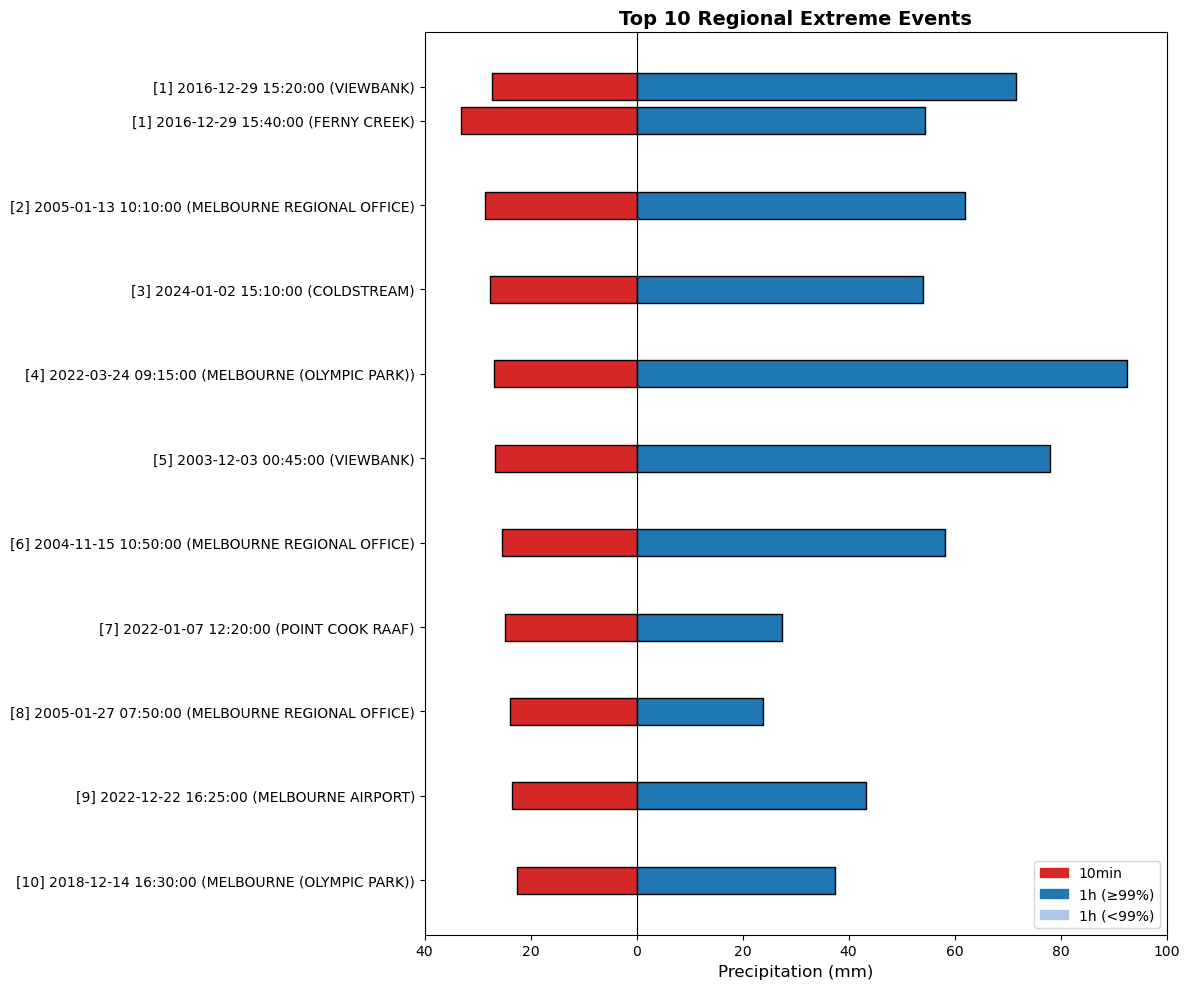

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load your CSV with date parsing
file_path = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv'
df = pd.read_csv(file_path, parse_dates=["Datetime_10min_Max", "Datetime_1h_Max"])

# Sort by rank and datetime
df = df.sort_values(["Rank", "Datetime_10min_Max"])

# Plot setup
fig, ax = plt.subplots(figsize=(12, 10))
y_labels = []
y_pos = []

# Bar styling
bar_height = 0.8
rank_gap = 1.5  # vertical space between rank groups
color_10min = "#d62728"
color_1h_above = "#1f77b4"
color_1h_below = "#aec7e8"

# Plot bars grouped by rank
y = 0
last_rank = None

for i, row in df.iterrows():
    if last_rank is not None and row["Rank"] != last_rank:
        y += rank_gap  # add gap between ranks

    # Label and position
    label = f"{[row['Rank']]} {row['Datetime_10min_Max']} ({row['Station']})"
    y_labels.append(label)
    y_pos.append(y)

    # 10-min bar (left side)
    ax.barh(
        y, -row["Daily_Max_10min"],
        color=color_10min,
        height=bar_height,
        edgecolor='black'
    )

    # 1-h bar (right side)
    color_1h = color_1h_above if row["Above_99p_1h"] == "Y" else color_1h_below
    ax.barh(
        y, row["Daily_Max_1h"],
        color=color_1h,
        height=bar_height,
        edgecolor='black'
    )

    y += 1
    last_rank = row["Rank"]

# Final aesthetics
ax.axvline(0, color="black", linewidth=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=10)
ax.set_xlabel("Precipitation (mm)", fontsize=12)
ax.set_title("Top 10 Regional Extreme Events", fontsize=14, weight='bold')
ax.tick_params(axis='x', labelsize=10)
ax.invert_yaxis()

# Custom legend
handles = [
    mpatches.Patch(color=color_10min, label="10min"),
    mpatches.Patch(color=color_1h_above, label="1h (≥99%)"),
    mpatches.Patch(color=color_1h_below, label="1h (<99%)")
]
ax.legend(handles=handles, loc='lower right', fontsize=10)

# Set symmetric x-ticks and show absolute values
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels([str(abs(int(x))) for x in xticks])

# Subtitles
xlim = ax.get_xlim()
ymax = max(y_pos) - 23.5
ax.text(xlim[0] + 27, ymax, "10min", fontsize=13, weight='bold', color=color_10min, ha='left', va='center')
ax.text(xlim[1] - 93, ymax, "1h", fontsize=13, weight='bold', color=color_1h_above, ha='right', va='center')

plt.tight_layout()
plt.savefig(f'{shape_path}/figure/top_10_groupbar_{region_name}.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


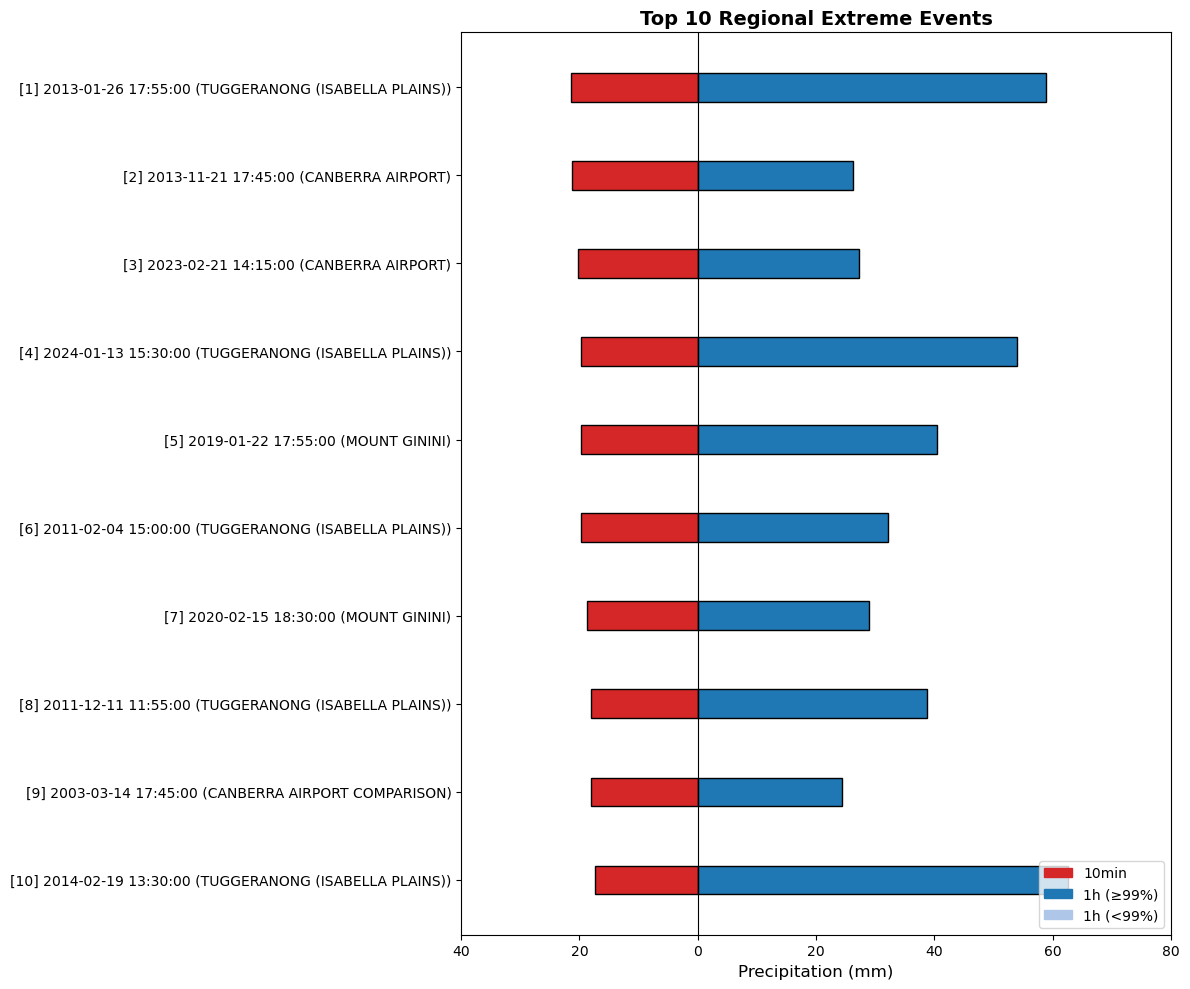

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load your CSV with date parsing
# Define the directory path
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
region_name = "Australian Capital Territory"

# --- File and Path Setup ---
shape_path = '/g/data/w28/yk8692/nesp'
file_path = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv'
df = pd.read_csv(file_path, parse_dates=["Datetime_10min_Max", "Datetime_1h_Max"])

# Sort by rank and datetime
df = df.sort_values(["Rank", "Datetime_10min_Max"])

# Plot setup
fig, ax = plt.subplots(figsize=(12, 10))
y_labels = []
y_pos = []

# Bar styling
bar_height = 0.8
rank_gap = 1.5  # vertical space between rank groups
color_10min = "#d62728"
color_1h_above = "#1f77b4"
color_1h_below = "#aec7e8"

# Plot bars grouped by rank
y = 0
last_rank = None

for i, row in df.iterrows():
    if last_rank is not None and row["Rank"] != last_rank:
        y += rank_gap  # add gap between ranks

    # Label and position
    label = f"{[row['Rank']]} {row['Datetime_10min_Max']} ({row['Station']})"
    y_labels.append(label)
    y_pos.append(y)

    # 10-min bar (left side)
    ax.barh(
        y, -row["Daily_Max_10min"],
        color=color_10min,
        height=bar_height,
        edgecolor='black'
    )

    # 1-h bar (right side)
    color_1h = color_1h_above if row["Above_99p_1h"] == "Y" else color_1h_below
    ax.barh(
        y, row["Daily_Max_1h"],
        color=color_1h,
        height=bar_height,
        edgecolor='black'
    )

    y += 1
    last_rank = row["Rank"]

# Final aesthetics
ax.axvline(0, color="black", linewidth=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=10)
ax.set_xlabel("Precipitation (mm)", fontsize=12)
ax.set_title("Top 10 Regional Extreme Events", fontsize=14, weight='bold')
ax.tick_params(axis='x', labelsize=10)
ax.invert_yaxis()

# Custom legend
handles = [
    mpatches.Patch(color=color_10min, label="10min"),
    mpatches.Patch(color=color_1h_above, label="1h (≥99%)"),
    mpatches.Patch(color=color_1h_below, label="1h (<99%)")
]
ax.legend(handles=handles, loc='lower right', fontsize=10)

# Set symmetric x-ticks and show absolute values
xticks = ax.get_xticks()
ax.set_xticks(xticks)
ax.set_xticklabels([str(abs(int(x))) for x in xticks])

# Subtitles
xlim = ax.get_xlim()
ymax = max(y_pos) - 23.5
# ax.text(xlim[0] + 27, ymax, "10min", fontsize=13, weight='bold', color=color_10min, ha='left', va='center')
# ax.text(xlim[1] - 93, ymax, "1h", fontsize=13, weight='bold', color=color_1h_above, ha='right', va='center')

plt.tight_layout()
plt.savefig(f'{shape_path}/figure/top_10_groupbar_{region_name}.png', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


In [3]:
region_name = 'Darwin'
shape_path = '/g/data/w28/yk8692/nesp'

summary_file = f"{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv"
df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max"])
# Make a copy so you don’t clobber your original
out = df.copy()

# ✅ Filter to keep only rows where 1h precipitation is above 99th percentile
out = out[out['Above_99p_1h'] == 'Y'].copy()

# 1) Add “Sr. no.” as a 1-based index
out.insert(0, 'Sr. no.', range(1, len(out) + 1))

# 2) Rename columns to match your desired headers
out = out.rename(columns={
    'Datetime_10min_Max':    'Time of 10min P',
    'Daily_Max_10min':       'Precipitation at 10min',
    'Datetime_1h_Max':       'Time of 1hr P',
    'Daily_Max_1h':          'Precipitation at 1hr',
    'Station':               'station name'
})

# 3) Select and order the columns exactly how you want
out = out[[
    'Sr. no.',
    'Time of 10min P',
    'Precipitation at 10min',
    'Time of 1hr P',
    'Precipitation at 1hr',
    'station name',
    'Longitude',
    'Latitude'
]]

# 4) Save to CSV
output_file = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon_formatted.csv'
out.to_csv(output_file, index=False)

# 5) (Optional) print to verify
print(out.head(10))

   Sr. no.     Time of 10min P  Precipitation at 10min        Time of 1hr P  \
0        1 2004-12-27 12:00:00                    48.8  2004-12-27 12:05:00   
1        2 2002-11-16 05:45:00                    30.8  2002-11-16 06:20:00   
2        3 2013-02-12 09:10:00                    27.6  2013-02-12 09:45:00   
3        4 2015-03-16 15:35:00                    27.6  2015-03-16 16:15:00   
4        5 2020-12-26 15:20:00                    27.2  2020-12-26 15:40:00   
5        6 2016-05-01 01:20:00                    25.8  2016-05-01 01:50:00   
6        7 2015-12-09 00:50:00                    25.8  2015-12-09 01:40:00   
9        8 2005-01-18 16:50:00                    24.2  2005-01-18 17:00:00   

   Precipitation at 1hr       station name  Longitude  Latitude  
0                  68.8     DARWIN AIRPORT   130.8925  -12.4239  
1                  56.0     DARWIN AIRPORT   130.8925  -12.4239  
2                  95.0     DARWIN AIRPORT   130.8925  -12.4239  
3                  37.8 

In [39]:
# Define the directory path
directory_path = "/g/data/w28/yk8692/nesp/station_corrected_rv"
region_name = "Melbourne"

# --- File and Path Setup ---
shape_path = '/g/data/w28/yk8692/nesp'
file_path = f'{shape_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon.csv'
top10_df = pd.read_csv(file_path, parse_dates=["Datetime_10min_Max", "Datetime_1h_Max"])
print(top10_df)
# Sort by rank and datetime
top10_df = top10_df.sort_values(["Rank", "Datetime_10min_Max"])

# Define the event filter
top4_conditions = (
    ((top10_df['Date'] == '2016-12-29') & (top10_df['Station'].str.contains('FERNY CREEK', case=False))) |
    ((top10_df['Date'] == '2016-12-29') & (top10_df['Station'].str.contains('VIEWBANK', case=False))) |
    ((top10_df['Date'] == '2024-01-02') & (top10_df['Station'].str.contains('COLDSTREAM', case=False))) |
    ((top10_df['Date'] == '2003-12-03') & (top10_df['Station'].str.contains('VIEWBANK', case=False))) |
    ((top10_df['Date'] == '2022-01-07') & (top10_df['Station'].str.contains('POINT COOK', case=False)))
)

# Apply filter
selected_rows = top10_df[top4_conditions].copy()

# Rename columns to match expected names in the plotting script
selected_rows.rename(columns={
    'Station_name': 'Station name',
    'Datetime_10min_Max': 'Time of 10min P',
    'Datetime_1h_Max': 'Time of 1hr P',
    'Daily_Max_10min': '10min P',
    'Daily_Max_1h': '1hr P',
    'Longitude': 'Lon',
    'Latitude': 'Lat'
}, inplace=True)

# Reset index just in case
selected_rows.reset_index(drop=True, inplace=True)

# Optional: Check result
print(selected_rows[['Date', 'Station', 'Time of 10min P', '10min P', 'Time of 1hr P', '1hr P', 'Lon', 'Lat']])

    Rank        Date                    Station  Latitude  Longitude  \
0      1  2016-12-29                FERNY CREEK  -37.8748   145.3497   
1      1  2016-12-29                   VIEWBANK  -37.7408   145.0972   
2      2  2005-01-13  MELBOURNE REGIONAL OFFICE  -37.8075   144.9700   
3      3  2024-01-02                 COLDSTREAM  -37.7239   145.4092   
4      4  2022-03-24   MELBOURNE (OLYMPIC PARK)  -37.8255   144.9816   
5      5  2003-12-03                   VIEWBANK  -37.7408   145.0972   
6      6  2004-11-15  MELBOURNE REGIONAL OFFICE  -37.8075   144.9700   
7      7  2022-01-07            POINT COOK RAAF  -37.9273   144.7566   
8      8  2005-01-27  MELBOURNE REGIONAL OFFICE  -37.8075   144.9700   
9      9  2022-12-22          MELBOURNE AIRPORT  -37.6654   144.8322   
10    10  2018-12-14   MELBOURNE (OLYMPIC PARK)  -37.8255   144.9816   

    Daily_Max_10min  Datetime_10min_Max  Daily_Max_1h     Datetime_1h_Max  \
0              33.2 2016-12-29 15:40:00          54.4 2016

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Load and fix all_stations_data ---
with open(f'{directory_path}/p2_event_windows_noNAN_all_stations_{region_name}.pkl', 'rb') as f:
    all_stations_data = pickle.load(f)

# Convert each station dict to DataFrame with datetime index
for station, data in all_stations_data.items():
    if isinstance(data, dict):
        if all(isinstance(v, (list, np.ndarray, pd.Series)) for v in data.values()):
            df = pd.DataFrame(data)
            if 'Time' in df.columns:
                df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
                df = df.dropna(subset=['Time'])
                df.set_index('Time', inplace=True)
                all_stations_data[station] = df
        else:
            print(f"⚠️ Skipping station '{station}' due to scalar or malformed values.")

# --- Extract daily data for selected events ---
daily_data_list = []
selected_rows['Time of 10min P'] = pd.to_datetime(selected_rows['Time of 10min P'])

for _, row in selected_rows.iterrows():
    station = row['Station']
    event_time = row['Time of 10min P']
    event_date = event_time.date()

    if station in all_stations_data:
        df_station = all_stations_data[station]
        day_start = pd.Timestamp(event_date)
        day_end = day_start + pd.Timedelta(days=1)
        day_data = df_station.loc[day_start:day_end - pd.Timedelta(minutes=1)].copy()
        day_data['Station'] = station
        day_data['Event Date'] = event_date
        daily_data_list.append(day_data)
    else:
        print(f"⚠️ Station '{station}' not found in all_stations_data.")


# Combine all into one DataFrame
full_day_data = pd.concat(daily_data_list).reset_index()
full_day_data.rename(columns={'index': 'Time'}, inplace=True)

# Variables and color
variables = ['Precipitation', 'Temperature', 'Relative Humidity', 'Wind Speed']
column_colors = ['lightskyblue', 'orange', 'lightgreen', 'pink']

# Top 5 events
events = selected_rows[['Station', 'Time of 10min P']].rename(
    columns={'Station name': 'Station', 'Time of 10min P': 'Event Time'}
).head(5)

# Create subplots
fig, axs = plt.subplots(nrows=len(events), ncols=len(variables),
                        figsize=(20, 3 * len(events)), sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Handle 1-row case
if len(events) == 1:
    axs = axs[np.newaxis, :]

# Plot each event
for row_idx, (_, event) in enumerate(events.iterrows()):
    station = event['Station']
    event_time = event['Event Time']
    event_date = event_time.date()

    data = full_day_data[(full_day_data['Station'] == station) &
                         (full_day_data['Event Date'] == event_date)].copy()

    for col_idx, (var, color) in enumerate(zip(variables, column_colors)):
        ax = axs[row_idx, col_idx]

        ax.axvline(event_time, color='black', linestyle=':', linewidth=1.8)

        if var in data.columns:
            ax.plot(data['Time'], data[var], label=var, color=color, linewidth=2)

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.set_xlim([data['Time'].min(), data['Time'].max()])
        ax.tick_params(axis='x', labelsize=11, rotation=45)
        ax.tick_params(axis='y', labelsize=11)
        ax.set_title(f"{var}" if col_idx == 0 else var, fontsize=12)

        if row_idx == len(events) - 1:
            ax.set_xlabel("Time of Day", fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(event_time.strftime('%Y-%m-%d %H:%M'), fontsize=12, fontweight='bold')
            ax.yaxis.set_label_coords(-0.15, 0.5)

        ax.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


⚠️ Skipping station 'FERNY CREEK (DUNNS HILL)' due to scalar or malformed values.
⚠️ Skipping station 'MELBOURNE REGIONAL OFFICE' due to scalar or malformed values.
⚠️ Skipping station 'SCORESBY RESEARCH INSTITUTE' due to scalar or malformed values.
⚠️ Skipping station 'LAVERTON RAAF' due to scalar or malformed values.
⚠️ Skipping station 'MELBOURNE (OLYMPIC PARK)' due to scalar or malformed values.
⚠️ Skipping station 'CERBERUS' due to scalar or malformed values.
⚠️ Skipping station 'FERNY CREEK' due to scalar or malformed values.
⚠️ Skipping station 'POINT COOK RAAF' due to scalar or malformed values.
⚠️ Skipping station 'FRANKSTON (BALLAM PARK)' due to scalar or malformed values.
⚠️ Skipping station 'WALLAN (KILMORE GAP)' due to scalar or malformed values.
⚠️ Skipping station 'MOORABBIN AIRPORT' due to scalar or malformed values.
⚠️ Skipping station 'VIEWBANK' due to scalar or malformed values.
⚠️ Skipping station 'FRANKSTON BEACH' due to scalar or malformed values.
⚠️ Skipping stat

AttributeError: 'dict' object has no attribute 'loc'

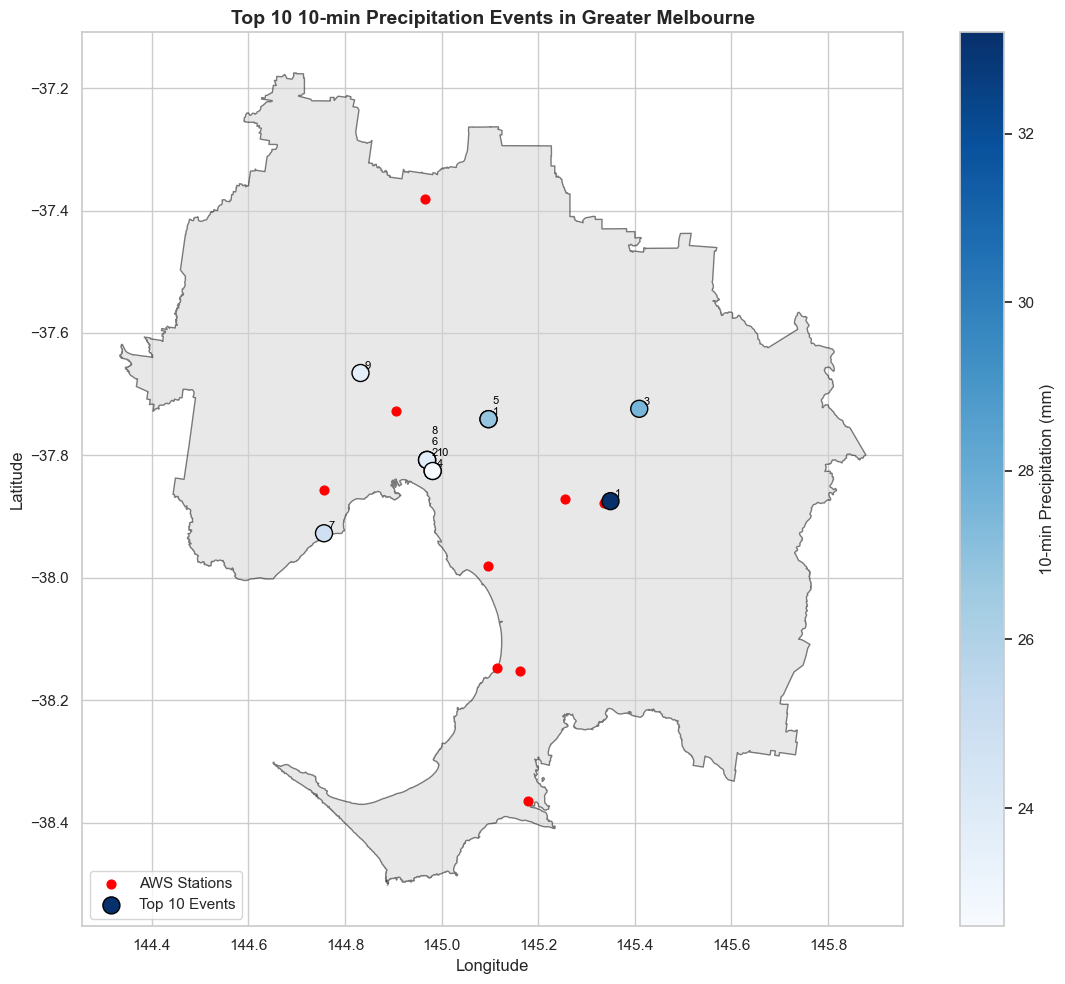

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import os

# --- File paths ---
base_path = "/g/data/w28/yk8692/nesp"
shapefile_path = os.path.join(f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/", "GCCSA_2021_AUST_GDA2020.shp")
stations_file = os.path.join(f"{base_path}/station/", "All_stations_information.xlsx")
summary_file = os.path.join(f"{base_path}/figure/", "Melbourne_top10_extreme_events_ranked.csv")
target_region = 'Melbourne'

# --- Load data ---
stations_df = pd.read_excel(stations_file)
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df['Longitude'], stations_df['Latitude']),
    crs="EPSG:4326"
)

# Load and extract Greater Melbourne region
melbourne_shp = gpd.read_file(shapefile_path)
melbourne_gdf = melbourne_shp[melbourne_shp["GCC_NAME21"].str.contains("Melbourne", case=False)].to_crs("EPSG:4326")

# Filter AWS stations within the Melbourne boundary
stations_in_melbourne = stations_gdf[stations_gdf.within(melbourne_gdf.unary_union)]

# Load summary of top 10 10-min extreme events
top10_df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max", "Datetime_1h_Max"])
# top10_df = top10_df[~((top10_df["Rank"] == 9) & (top10_df["Above_99p_1h"] != "Y"))]
top10_df = top10_df[(top10_df["Above_99p_1h"] == "Y")]

# Merge to attach coordinates
top10_df = top10_df.merge(
    stations_df[["Station_name", "Longitude", "Latitude"]],
    left_on="Station", right_on="Station_name", how="left"
)

# Convert to GeoDataFrame
top10_gdf = gpd.GeoDataFrame(
    top10_df,
    geometry=gpd.points_from_xy(top10_df["Longitude"], top10_df["Latitude"]),
    crs="EPSG:4326"
)

# --- Plotting ---
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Melbourne boundary
melbourne_gdf.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Plot AWS stations
stations_in_melbourne.plot(ax=ax, color='red', markersize=40, label='AWS Stations')

# Scatter plot for top 10 events
sc = ax.scatter(
    top10_gdf.geometry.x,
    top10_gdf.geometry.y,
    c=top10_gdf['Daily_Max_10min'],
    cmap='Blues',
    s=150,
    edgecolor='black',
    label='Top 10 Events',
    zorder=3
)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical')
cbar.set_label("10-min Precipitation (mm)", fontsize=12)

# Use DBSCAN to prevent overlapping text labels
coords = np.array([[geom.x, geom.y] for geom in top10_gdf.geometry])
db = DBSCAN(eps=0.005, min_samples=1).fit(coords)
top10_gdf['cluster'] = db.labels_

offsets = {}
for cluster in top10_gdf['cluster'].unique():
    cluster_points = top10_gdf[top10_gdf['cluster'] == cluster]
    sorted_indices = cluster_points.sort_values(by='Latitude').index
    for j, idx in enumerate(sorted_indices):
        offsets[idx] = 3 + j * 8

# Annotate each top 10 event with rank and station
for idx, row in top10_gdf.iterrows():
    label = f"{int(row['Rank'])}"
    offset_y = offsets.get(idx, 3)
    ax.annotate(
        label,
        xy=(row.geometry.x, row.geometry.y),
        xytext=(3, offset_y),
        textcoords="offset points",
        fontsize=8,
        color="black"
    )

# Final plot settings
ax.set_title("Top 10 10-min Precipitation Events in Greater Melbourne", fontsize=14, fontweight="bold")
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend(loc='lower left')
plt.tight_layout()

# Save
# plt.savefig(f'{base_path}/figure/top_10_map_{target_region}.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.savefig(f'{base_path}/figure/top_10_map_{target_region}.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
import pandas as pd
import os

# --- File paths ---
base_path = "/g/data/w28/yk8692/nesp"
stations_file = os.path.join(f"{base_path}/station/", "All_stations_information.xlsx")
summary_file = os.path.join(f"{base_path}/figure/", "Melbourne_top10_all_summary.csv")

# --- Load data ---
stations_df = pd.read_excel(stations_file)

# Load summary of top 10 10-min extreme events
top10_df = pd.read_csv(summary_file, parse_dates=["Datetime_10min_Max", "Datetime_1h_Max"])
# top10_df = top10_df[~((top10_df["Rank"] == 9) & (top10_df["Above_99p_1h"] != "Y"))]
top10_df = top10_df[(top10_df["Above_99p_1h"] == "Y")]

# Merge to attach coordinates
top10_df = top10_df.merge(
    stations_df[["Station_name", "Longitude", "Latitude"]],
    left_on="Station", right_on="Station_name", how="left"
).drop(columns=["Station_name"])

shape_path = '/g/data/w28/yk8692/nesp'
target_region = 'Melbourne'

file_path = f'{shape_path}/figure/{target_region}_top10_after_hourly_check_summary.csv'
top10_df.to_csv(file_path, index=False)